## Feature Extraction: CD

In [3]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.correlationdimension import EEGCorrelationDimension
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250
EEG_DIR_PATH = os.getenv("EEG_DIR_PATH")
RAW_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/raw"
SELECT_16_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/16channels"
FILTERED_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/filtered"
EPOCHS_DIR_PATH = os.getenv("EEG_DIR_PATH") + "/epochs"

# Declare Feature Dictionary
featureDict = {
    "CD": {
        "mdd": [],
        "control": []
    }
}

ModuleNotFoundError: No module named 'brainmdd.features.correlationdimension'

In [2]:
# Load the epochs
mddEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/mdd-epo.fif")
controlEpochs = mne.read_epochs(EPOCHS_DIR_PATH + "/control-epo.fif")
mddEpochs = mddEpochs.get_data()
controlEpochs = controlEpochs.get_data()
print(mddEpochs.shape)
print(controlEpochs.shape)

NameError: name 'mne' is not defined

In [4]:
cdObjMdd = EEGCorrelationDimension(mddEpochs)
mddCdFeatures = cdObjMdd.run()
cdObjControl = EEGCorrelationDimension(controlEpochs)
controlCdFeatures = cdObjControl.run()

for epoch in mddCdFeatures:
    featureDict["CD"]["mdd"].append(epoch)
for epoch in controlCdFeatures:
    featureDict["CD"]["control"].append(epoch)

## Classification

In [5]:
import os
import numpy as np
import pickle
import warnings
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
CdMdd = featureDict["CD"]["mdd"]
CdControl = featureDict["CD"]["control"]

X = np.concatenate((CdMdd, CdControl), axis=0)
y = np.concatenate((np.ones(len(CdMdd)), np.zeros(len(CdControl))), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # why 42?

def save_model(model, feature_type, model_name):
    folder_path = os.path.join("models", feature_type)
    os.makedirs(folder_path, exist_ok=True)  # Create folder if not exists
    model_path = os.path.join(folder_path, f"{model_name}.pkl")
    with open(model_path, "wb") as file:
        pickle.dump(model, file)
    print(f"✅ Model saved: {model_path}")

models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "LDA": (LinearDiscriminantAnalysis(), {"solver": ["svd", "lsqr", "eigen"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [3, 5, 10], "criterion": ["gini", "entropy"]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100, 200], "max_depth": [5, 10]}),
    "Logistic Regression": (LogisticRegression(), {"C": [0.1, 1, 10], "solver": ["lbfgs", "liblinear"]}),
}

best_models = {}
feature_type = "CD"  

for name, (model, param_grid) in models.items():
    print(f"🔍 Tuning {name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    best_models[name] = (best_model, accuracy, best_params)

    print(f"✅ Best {name} Parameters: {best_params}")
    print(f"🔢 {name} Accuracy: {accuracy:.4f}\n")
    save_model(best_model, feature_type, name)

print("\n=== Best Models Summary ===")
for name, (model, accuracy, params) in best_models.items():
    print(f"{name}: Accuracy={accuracy:.4f}, Best Params={params}")


🔍 Tuning KNN...
✅ Best KNN Parameters: {'n_neighbors': 3, 'weights': 'uniform'}
🔢 KNN Accuracy: 0.5186

✅ Model saved: models/CD/KNN.pkl
🔍 Tuning SVM...
✅ Best SVM Parameters: {'C': 0.1, 'kernel': 'linear'}
🔢 SVM Accuracy: 0.5397

✅ Model saved: models/CD/SVM.pkl
🔍 Tuning LDA...
✅ Best LDA Parameters: {'solver': 'svd'}
🔢 LDA Accuracy: 0.5332

✅ Model saved: models/CD/LDA.pkl
🔍 Tuning Decision Tree...
✅ Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3}
🔢 Decision Tree Accuracy: 0.5251

✅ Model saved: models/CD/Decision Tree.pkl
🔍 Tuning Random Forest...
✅ Best Random Forest Parameters: {'max_depth': 5, 'n_estimators': 100}
🔢 Random Forest Accuracy: 0.5381

✅ Model saved: models/CD/Random Forest.pkl
🔍 Tuning Logistic Regression...
✅ Best Logistic Regression Parameters: {'C': 10, 'solver': 'liblinear'}
🔢 Logistic Regression Accuracy: 0.5397

✅ Model saved: models/CD/Logistic Regression.pkl

=== Best Models Summary ===
KNN: Accuracy=0.5186, Best Params={'n_neighbors':

In [2]:
# import pickle file and test
import pickle
with open("models/CD/KNN.pkl", "rb") as file:
    model = pickle.load(file)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(y_pred)
    print(y_test)
    print(y_pred == y_test)
    print(np.sum(y_pred == y_test))
    
    # print(y_pred)
    

NameError: name 'X_test' is not defined

0.5186385737439222
[[201 132]
 [165 119]]
              precision    recall  f1-score   support

         0.0       0.55      0.60      0.58       333
         1.0       0.47      0.42      0.44       284

    accuracy                           0.52       617
   macro avg       0.51      0.51      0.51       617
weighted avg       0.51      0.52      0.52       617

accuracy_score:  0.5186385737439222


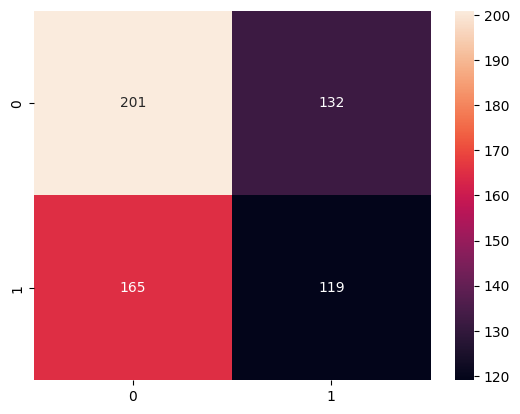

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

CdMdd = featureDict["CD"]["mdd"]
CdControl = featureDict["CD"]["control"]

X = np.concatenate((CdMdd, CdControl), axis=0)
y = np.concatenate((np.ones(len(CdMdd)), np.zeros(len(CdControl))), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print("accuracy_score: ", accuracy_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [1]:
import os
import numpy as np
import pickle
import warnings
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")


# EEG Power Spectrum Extraction Class
class EEGPowerSpectrum:
    def __init__(self, data, fs, ifNormalize=True):
        self.data = data
        self.fs = fs
        self.freqs = None
        self.psd = None
        self.deltaPsd = None
        self.thetaPsd = None
        self.alphaPsd = None
        self.betaPsd = None
        self.gammaPsd = None
        self.isNormalized = ifNormalize

    def compute_power_spectrum(self, data):
        self.freqs, self.psd = signal.welch(data, fs=self.fs, nperseg=self.fs, noverlap=self.fs // 2)

    def compute_band_power(self):
        self.deltaPsd = self.psd[(self.freqs >= 0.5) & (self.freqs < 4)].sum()
        self.thetaPsd = self.psd[(self.freqs >= 4) & (self.freqs < 8)].sum()
        self.alphaPsd = self.psd[(self.freqs >= 8) & (self.freqs < 12)].sum()
        self.betaPsd = self.psd[(self.freqs >= 12) & (self.freqs < 28)].sum()
        self.gammaPsd = self.psd[(self.freqs >= 28) & (self.freqs < 40)].sum()
        self.eegPsd = self.psd[(self.freqs >= 0.5) & (self.freqs < 40)].sum()

        if self.isNormalized:
            self.deltaPsd /= self.eegPsd
            self.thetaPsd /= self.eegPsd
            self.alphaPsd /= self.eegPsd
            self.betaPsd /= self.eegPsd
            self.gammaPsd /= self.eegPsd

    def run(self):
        results = []
        for epoch in self.data:
            eachEpoch = []
            for channel in epoch:
                self.compute_power_spectrum(channel)
                self.compute_band_power()
                eachEpoch.append([self.deltaPsd, self.thetaPsd, self.alphaPsd, self.betaPsd, self.gammaPsd])
            results.append(eachEpoch)
        results = np.array(results)
        results = np.transpose(results, (0, 2, 1))
        return np.array(results)


# Function to save model in a structured directory
def save_model(model, feature_type, model_name):
    folder_path = os.path.join("models", feature_type)
    os.makedirs(folder_path, exist_ok=True)  # Create subfolder if not exist
    model_path = os.path.join(folder_path, f"{model_name}.pkl")
    with open(model_path, "wb") as file:
        pickle.dump(model, file)
    print(f"✅ Model saved: {model_path}")


# Simulated EEG Dataset (Replace with real EEG feature matrix)
np.random.seed(42)
X = np.random.randn(200, 16)  # 200 samples, 16 EEG channels
y = np.random.randint(0, 2, 200)  # Binary labels (0 or 1)

# Power Spectrum Extraction
eegPowerSpectrum = EEGPowerSpectrum(X.reshape(200, 16, 1), fs=256)
features = eegPowerSpectrum.run().reshape(200, -1)  # Flatten the feature vector

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Machine Learning Models and Hyperparameters
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}),
    "SVM": (SVC(), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "LDA": (LinearDiscriminantAnalysis(), {"solver": ["svd", "lsqr", "eigen"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [3, 5, 10], "criterion": ["gini", "entropy"]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100, 200], "max_depth": [5, 10]}),
    "Logistic Regression": (LogisticRegression(), {"C": [0.1, 1, 10], "solver": ["lbfgs", "liblinear"]}),
}

# Loop through models and perform hyperparameter tuning
best_models = {}
feature_type = "PowerSpectrum"

for name, (model, param_grid) in models.items():
    print(f"🔍 Tuning {name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    best_models[name] = (best_model, accuracy, best_params)

    print(f"✅ Best {name} Parameters: {best_params}")
    print(f"🔢 {name} Accuracy: {accuracy:.4f}\n")

    # Save the best model
    save_model(best_model, feature_type, name)

# Summary of all best models
print("\n=== Best Models Summary ===")
for name, (model, accuracy, params) in best_models.items():
    print(f"{name}: Accuracy={accuracy:.4f}, Best Params={params}")


ValueError: noverlap must be less than nperseg.